## Classificatori di cucina 1

In questa lezione, esploreremo una varietà di classificatori per *predire una cucina nazionale specifica basandoci su un gruppo di ingredienti.* Durante questo processo, approfondiremo alcuni dei modi in cui gli algoritmi possono essere utilizzati per compiti di classificazione.

### [**Quiz pre-lezione**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Preparazione**

Questa lezione si basa sulla nostra [lezione precedente](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) in cui:

-   Abbiamo fatto una leggera introduzione alle classificazioni utilizzando un dataset sulle meravigliose cucine dell'Asia e dell'India 😋.

-   Abbiamo esplorato alcuni [verbi di dplyr](https://dplyr.tidyverse.org/) per preparare e pulire i nostri dati.

-   Abbiamo creato splendide visualizzazioni utilizzando ggplot2.

-   Abbiamo dimostrato come gestire dati sbilanciati preprocessandoli con [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Abbiamo mostrato come `prep` e `bake` la nostra ricetta per confermare che funzionerà come previsto.

#### **Prerequisiti**

Per questa lezione, avremo bisogno dei seguenti pacchetti per pulire, preparare e visualizzare i nostri dati:

-   `tidyverse`: Il [tidyverse](https://www.tidyverse.org/) è una [collezione di pacchetti R](https://www.tidyverse.org/packages) progettata per rendere la scienza dei dati più veloce, facile e divertente!

-   `tidymodels`: Il framework [tidymodels](https://www.tidymodels.org/) è una [collezione di pacchetti](https://www.tidymodels.org/packages/) per la modellazione e il machine learning.

-   `themis`: Il pacchetto [themis](https://themis.tidymodels.org/) fornisce passaggi extra per la gestione di dati sbilanciati.

-   `nnet`: Il pacchetto [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) offre funzioni per stimare reti neurali feed-forward con un singolo strato nascosto e modelli di regressione logistica multinomiale.

Puoi installarli come:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

In alternativa, lo script seguente verifica se hai i pacchetti necessari per completare questo modulo e li installa per te nel caso in cui manchino.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Dividi i dati in set di addestramento e di test.

Inizieremo riprendendo alcuni passaggi dalla nostra lezione precedente.

### Elimina gli ingredienti più comuni che creano confusione tra le diverse cucine, utilizzando `dplyr::select()`.

Tutti amano il riso, l'aglio e lo zenzero!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfetto! Ora è il momento di suddividere i dati in modo che il 70% vada al training e il 30% al testing. Applicheremo anche una tecnica di `stratificazione` durante la suddivisione dei dati per `mantenere la proporzione di ciascuna cucina` nei dataset di training e validazione.

[rsample](https://rsample.tidymodels.org/), un pacchetto di Tidymodels, fornisce un'infrastruttura per una suddivisione e un campionamento dei dati efficiente:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Gestire i dati sbilanciati

Come avrai notato nel set di dati originale così come nel nostro set di addestramento, c'è una distribuzione piuttosto diseguale nel numero di cucine. Le cucine coreane sono *quasi* 3 volte quelle tailandesi. I dati sbilanciati spesso hanno effetti negativi sulle prestazioni del modello. Molti modelli funzionano meglio quando il numero di osservazioni è uguale e, di conseguenza, tendono a incontrare difficoltà con dati non bilanciati.

Ci sono principalmente due modi per gestire set di dati sbilanciati:

-   aggiungere osservazioni alla classe minoritaria: `Over-sampling`, ad esempio utilizzando un algoritmo SMOTE che genera sinteticamente nuovi esempi della classe minoritaria utilizzando i vicini più prossimi di questi casi.

-   rimuovere osservazioni dalla classe maggioritaria: `Under-sampling`

Nella lezione precedente, abbiamo dimostrato come gestire set di dati sbilanciati utilizzando una `ricetta`. Una ricetta può essere considerata come un piano che descrive quali passaggi devono essere applicati a un set di dati per prepararlo all'analisi. Nel nostro caso, vogliamo ottenere una distribuzione equa nel numero delle nostre cucine per il nostro `set di addestramento`. Entriamo subito nel dettaglio.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Puoi ovviamente confermare (usando prep+bake) che la ricetta funzioni come previsto - tutte le etichette di cucina con `559` osservazioni.

Poiché utilizzeremo questa ricetta come preprocessore per il modello, un `workflow()` si occuperà di tutto il prep e bake per noi, quindi non dovremo stimare manualmente la ricetta.

Ora siamo pronti per addestrare un modello 👩‍💻👨‍💻!

## 3. Scegliere il tuo classificatore

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Illustrazione di @allison_horst</figcaption>


Ora dobbiamo decidere quale algoritmo utilizzare per il lavoro 🤔.

In Tidymodels, il [`pacchetto parsnip`](https://parsnip.tidymodels.org/index.html) fornisce un'interfaccia coerente per lavorare con i modelli su diversi motori (pacchetti). Consulta la documentazione di parsnip per esplorare [tipi di modelli e motori](https://www.tidymodels.org/find/parsnip/#models) e i loro corrispondenti [argomenti dei modelli](https://www.tidymodels.org/find/parsnip/#model-args). La varietà può sembrare piuttosto sconcertante a prima vista. Ad esempio, i seguenti metodi includono tecniche di classificazione:

-   Modelli di classificazione basati su regole C5.0

-   Modelli di discriminante flessibile

-   Modelli di discriminante lineare

-   Modelli di discriminante regolarizzati

-   Modelli di regressione logistica

-   Modelli di regressione multinomiale

-   Modelli di Naive Bayes

-   Macchine a vettori di supporto

-   Vicini più prossimi

-   Alberi decisionali

-   Metodi di ensemble

-   Reti neurali

La lista continua!

### **Quale classificatore scegliere?**

Quindi, quale classificatore dovresti scegliere? Spesso, provare diversi e cercare un buon risultato è un modo per testare.

> AutoML risolve questo problema in modo efficace eseguendo questi confronti nel cloud, permettendoti di scegliere il miglior algoritmo per i tuoi dati. Provalo [qui](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Inoltre, la scelta del classificatore dipende dal nostro problema. Ad esempio, quando il risultato può essere categorizzato in `più di due classi`, come nel nostro caso, è necessario utilizzare un `algoritmo di classificazione multiclass` anziché una `classificazione binaria`.

### **Un approccio migliore**

Un approccio migliore rispetto a indovinare casualmente, tuttavia, è seguire le idee contenute in questo [ML Cheat sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott) scaricabile. Qui scopriamo che, per il nostro problema multiclass, abbiamo alcune opzioni:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Una sezione del Cheat Sheet sugli algoritmi di Microsoft, che dettaglia le opzioni di classificazione multiclass</figcaption>


### **Ragionamento**

Vediamo se possiamo ragionare su diversi approcci dati i vincoli che abbiamo:

-   **Le reti neurali profonde sono troppo pesanti**. Considerando il nostro dataset pulito ma minimale e il fatto che stiamo eseguendo l'addestramento localmente tramite notebook, le reti neurali profonde sono troppo pesanti per questo compito.

-   **Nessun classificatore a due classi**. Non utilizziamo un classificatore a due classi, quindi escludiamo l'approccio one-vs-all.

-   **Un albero decisionale o una regressione logistica potrebbero funzionare**. Un albero decisionale potrebbe funzionare, oppure una regressione multinomiale/regressione logistica multiclass per dati multiclass.

-   **Gli alberi decisionali potenziati multiclass risolvono un problema diverso**. Gli alberi decisionali potenziati multiclass sono più adatti per compiti non parametrici, ad esempio compiti progettati per costruire classifiche, quindi non sono utili per noi.

Inoltre, normalmente prima di intraprendere modelli di machine learning più complessi, come i metodi ensemble, è una buona idea costruire il modello più semplice possibile per avere un'idea di cosa sta succedendo. Quindi, per questa lezione, inizieremo con un modello di `regressione multinomiale`.

> La regressione logistica è una tecnica utilizzata quando la variabile di output è categorica (o nominale). Per la regressione logistica binaria il numero di variabili di output è due, mentre per la regressione logistica multinomiale il numero di variabili di output è maggiore di due. Vedi [Metodi di regressione avanzati](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) per ulteriori approfondimenti.

## 4. Addestrare e valutare un modello di regressione logistica multinomiale.

In Tidymodels, `parsnip::multinom_reg()` definisce un modello che utilizza predittori lineari per prevedere dati multiclass utilizzando la distribuzione multinomiale. Vedi `?multinom_reg()` per i diversi modi/motori che puoi utilizzare per adattare questo modello.

Per questo esempio, adatteremo un modello di regressione multinomiale tramite il motore predefinito [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> Ho scelto un valore per `penalty` in modo piuttosto casuale. Esistono modi migliori per scegliere questo valore, ovvero utilizzando `resampling` e `tuning` del modello, che discuteremo più avanti.
>
> Vedi [Tidymodels: Get Started](https://www.tidymodels.org/start/tuning/) nel caso tu voglia approfondire come ottimizzare gli iperparametri del modello.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Ottimo lavoro 🥳! Ora che abbiamo una ricetta e una specifica del modello, dobbiamo trovare un modo per unirle in un unico oggetto che prima pre-elabori i dati, poi adatti il modello sui dati pre-elaborati e consenta anche eventuali attività di post-elaborazione. In Tidymodels, questo pratico oggetto si chiama [`workflow`](https://workflows.tidymodels.org/) e contiene comodamente i tuoi componenti di modellazione! Questo è ciò che chiameremmo *pipeline* in *Python*.

Quindi, mettiamo tutto insieme in un workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Workflows 👌👌! Un **`workflow()`** può essere adattato nello stesso modo in cui può esserlo un modello. Quindi, è ora di addestrare un modello!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

I coefficienti mostrano i valori che il modello ha appreso durante l'addestramento.

### Valutare il Modello Addestrato

È il momento di vedere come si è comportato il modello 📏 valutandolo su un set di test! Iniziamo facendo previsioni sul set di test.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Ottimo lavoro! In Tidymodels, la valutazione delle prestazioni del modello può essere effettuata utilizzando [yardstick](https://yardstick.tidymodels.org/) - un pacchetto utilizzato per misurare l'efficacia dei modelli tramite metriche di prestazione. Come abbiamo fatto nella lezione sulla regressione logistica, iniziamo calcolando una matrice di confusione.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

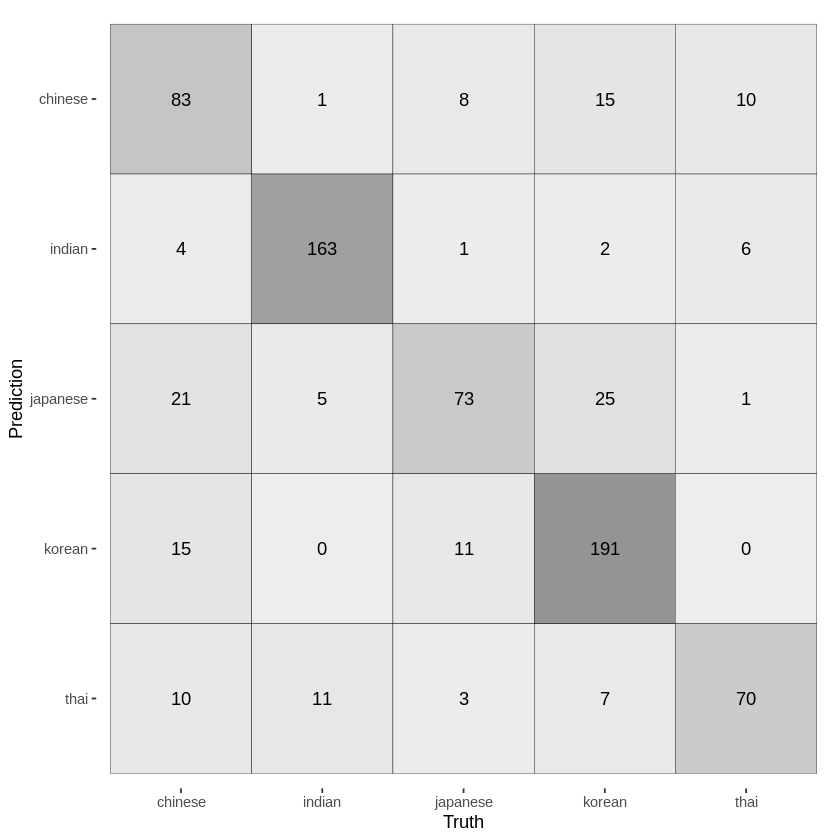

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

I quadrati più scuri nel grafico della matrice di confusione indicano un numero elevato di casi, e si dovrebbe notare una linea diagonale di quadrati più scuri che rappresenta i casi in cui l'etichetta prevista e quella reale coincidono.

Calcoliamo ora le statistiche riassuntive per la matrice di confusione.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Se ci concentriamo su alcune metriche come accuratezza, sensibilità, ppv, non siamo messi male per iniziare 🥳!

## 4. Approfondiamo

Poniamoci una domanda sottile: Quali criteri vengono utilizzati per scegliere un determinato tipo di cucina come risultato previsto?

Beh, gli algoritmi di apprendimento automatico statistico, come la regressione logistica, si basano sulla `probabilità`; quindi ciò che viene effettivamente previsto da un classificatore è una distribuzione di probabilità su un insieme di possibili risultati. La classe con la probabilità più alta viene quindi scelta come risultato più probabile per le osservazioni date.

Vediamo questo in azione facendo sia previsioni di classe rigide che probabilità.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

Molto meglio!

✅ Puoi spiegare perché il modello è abbastanza sicuro che la prima osservazione sia tailandese?

## **🚀Sfida**

In questa lezione, hai utilizzato i tuoi dati puliti per costruire un modello di machine learning in grado di prevedere una cucina nazionale basandosi su una serie di ingredienti. Prenditi del tempo per leggere le [molte opzioni](https://www.tidymodels.org/find/parsnip/#models) che Tidymodels offre per classificare i dati e [altri modi](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) per adattare la regressione multinomiale.

#### GRAZIE A:

[`Allison Horst`](https://twitter.com/allison_horst/) per aver creato le incredibili illustrazioni che rendono R più accogliente e coinvolgente. Trova altre illustrazioni nella sua [galleria](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) e [Jen Looper](https://www.twitter.com/jenlooper) per aver creato la versione originale in Python di questo modulo ♥️

<br>
Avrei inserito qualche battuta, ma non capisco i giochi di parole sul cibo 😅.

<br>

Buono studio,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Disclaimer**:  
Questo documento è stato tradotto utilizzando il servizio di traduzione automatica [Co-op Translator](https://github.com/Azure/co-op-translator). Sebbene ci impegniamo per garantire l'accuratezza, si prega di notare che le traduzioni automatiche possono contenere errori o imprecisioni. Il documento originale nella sua lingua nativa dovrebbe essere considerato la fonte autorevole. Per informazioni critiche, si raccomanda una traduzione professionale effettuata da un traduttore umano. Non siamo responsabili per eventuali incomprensioni o interpretazioni errate derivanti dall'uso di questa traduzione.
